# How to Evaluate - BERT Model for Binary Text Classification

This notebook provides step-by-step instructions to reproduce the results on your local machine.

## Prerequisites

### 1. System Requirements
- Python 3.8+
- GPU with CUDA support (recommended: NVIDIA GPU with 16GB+ VRAM)
- At least 32GB RAM
- 10GB free disk space

### 2. Install Dependencies

```bash

python -m venv venv
source venv/bin/activate

pip install -r requirements.txt
```

### 3. Verify PyTorch CUDA Installation

Run the following cell to check if CUDA is available:

In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 25.29 GB


## Option 1: Evaluate Pre-trained Model (Recommended)

If you have the saved model from training (`./bert_model_best/`), you can load it directly and evaluate.

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Load Pre-trained Model

In [3]:
MODEL_PATH = './bert_model_best'

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()

print(f"✓ Model loaded from {MODEL_PATH}")

The tokenizer you are loading from './bert_model_best' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Model loaded from ./bert_model_best


### Load and Preprocess Test Data

In [4]:
import re

def clean_text_for_bert(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^А-Яа-яёЁA-Za-z0-9\s\.,!?;:()"\'-]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df = pd.read_csv('nulp-military-experience/to_answer.csv')

test_df['text_cleaned'] = test_df['cleaned_message'].apply(clean_text_for_bert)
test_df['text'] = '[' + test_df['channel_name'].astype(str) + '] ' + test_df['text_cleaned']

print(f"Test data loaded: {len(test_df)} samples")

Test data loaded: 2271 samples


### Create Dataset and DataLoader

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=160):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

test_dataset = TextDataset(test_df['text'].values, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"✓ Test dataset created: {len(test_loader)} batches")

✓ Test dataset created: 142 batches


### Generate Predictions

In [6]:
predictions = []
probabilities = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predicting'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(outputs.logits, dim=1)
        
        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

print(f"✓ Predictions completed")
print(f"\nClass distribution:")
unique, counts = np.unique(predictions, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {int(cls)}: {cnt} ({cnt/len(predictions)*100:.1f}%)")

Predicting:   0%|          | 0/142 [00:00<?, ?it/s]

✓ Predictions completed

Class distribution:
  Class 0: 1638 (72.1%)
  Class 1: 633 (27.9%)


### Save Predictions

In [7]:
submission = test_df[['row ID']].copy()
submission['predicted_label'] = [int(p) for p in predictions]
submission.to_csv('predictions_bert_eval.csv', index=False)

print(f"✓ Predictions saved to 'predictions_bert_eval.csv'")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

✓ Predictions saved to 'predictions_bert_eval.csv'

First 10 predictions:
   row ID  predicted_label
0       0                0
1       1                0
2       2                0
3       3                1
4       4                1
5       5                0
6       6                0
7       7                0
8       8                0
9       9                1


### Analyze Prediction Confidence

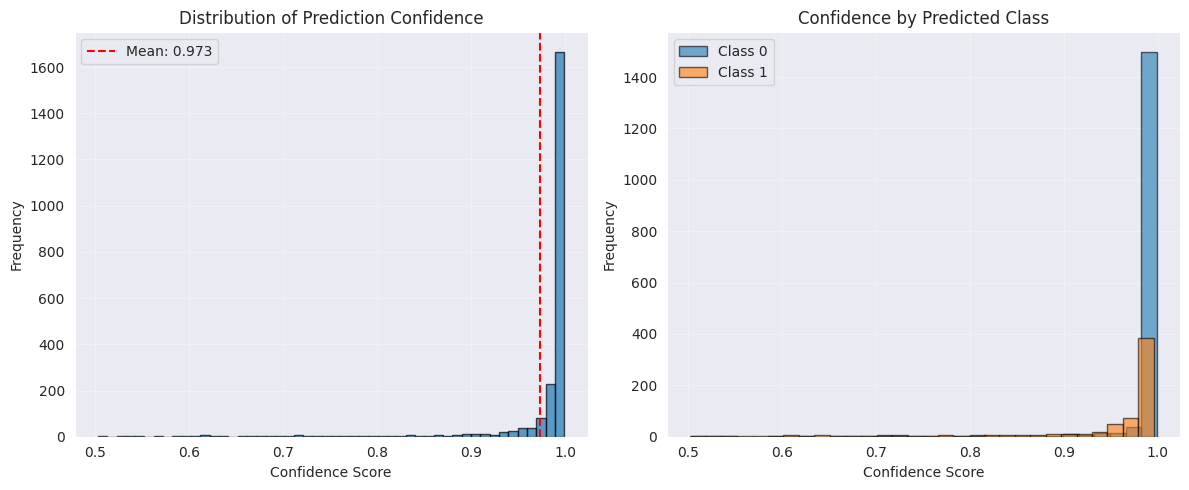


Confidence Statistics:
  Mean: 0.9732
  Std:  0.0687
  Min:  0.5025
  Max:  0.9988

Low confidence predictions (<0.6): 18 (0.8%)


In [8]:
probabilities = np.array(probabilities)
confidence_scores = np.max(probabilities, axis=1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidence_scores, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', label=f'Mean: {confidence_scores.mean():.3f}')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
for cls in [0, 1]:
    mask = np.array(predictions) == cls
    plt.hist(confidence_scores[mask], bins=30, alpha=0.6, label=f'Class {cls}', edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence by Predicted Class')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Mean: {confidence_scores.mean():.4f}")
print(f"  Std:  {confidence_scores.std():.4f}")
print(f"  Min:  {confidence_scores.min():.4f}")
print(f"  Max:  {confidence_scores.max():.4f}")
print(f"\nLow confidence predictions (<0.6): {(confidence_scores < 0.6).sum()} ({(confidence_scores < 0.6).sum()/len(confidence_scores)*100:.1f}%)")

## Option 2: Train from Scratch

If you want to reproduce the training process, simply run the entire `bert.ipynb` notebook. It will:

1. Load and preprocess training data
2. Apply data augmentation to minority class
3. Train XLM-RoBERTa-large model for 15 epochs
4. Use focal loss with gradient accumulation
5. Save the best model based on validation F1 score
6. Generate predictions for test set

**Expected Training Time:** ~30 minutes on NVIDIA RTX 3090

**Expected Results:**
- Validation F1 Score: ~0.83
- Validation Accuracy: ~0.89
- Validation Precision: ~0.81
- Validation Recall: ~0.80

## Troubleshooting

### CUDA Out of Memory
If you encounter CUDA OOM errors:
```python
# Reduce batch size in bert.ipynb:
BATCH_SIZE = 8  # instead of 16
GRADIENT_ACCUMULATION_STEPS = 4  # instead of 2
```

### Model Not Found
If `./bert_model_best/` doesn't exist, you need to:
1. Run `bert.ipynb` completely to train and save the model
2. Or download pre-trained model if available

### Slow CPU Training
Training on CPU is very slow (10-20x slower). Consider:
1. Using Google Colab with free GPU
2. Using a smaller model: `MODEL_NAME = 'xlm-roberta-base'`
3. Reducing epochs: `NUM_EPOCHS = 5`